In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# 1. 題目定義

我們的目標是預測加州房價,並了解哪些特徵對房價影響最大。

# 2. 資料觀察

In [19]:
# load data
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

# 查看data基本信息
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
2

# 3. Data preprocessing

In [20]:
# 检查缺失值
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

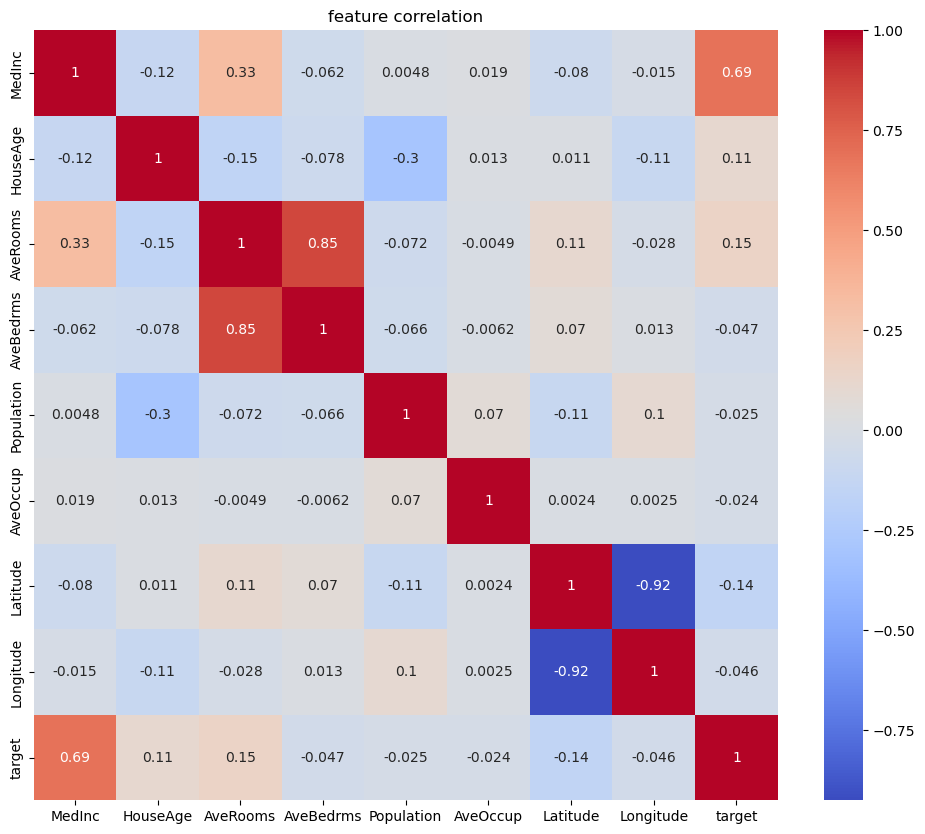

In [22]:
# 相關性分析
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('feature correlation')
plt.show()

In [23]:
X = df.drop(columns=['target'])
y = df['target']

In [24]:
# feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
model_rfe = LinearRegression()
rfe_selector = RFE(estimator=model_rfe, n_features_to_select=5, step=1)
rfe_selector = rfe_selector.fit(X_scaled, y)

# 獲取選定的特徵
selected_features = X.columns[rfe_selector.support_].tolist()
print("選定特徵：", selected_features)

選定特徵： ['MedInc', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']


In [27]:
# 使用選定特徵
X_selected = X[selected_features]

# 4. Model building

In [28]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [29]:
# build model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
# predict
y_pred = model.predict(X_test)
# evaluation

# 5. Evaluation

In [31]:
# MSE
mse = mean_squared_error(y_test, y_pred)
# R2
r2 = r2_score(y_test, y_pred)

print(f'均方誤差 (MSE): {mse}')
print(f'决定係數 (R²): {r2}')

均方誤差 (MSE): 0.5667695170781497
决定係數 (R²): 0.5674865431409175


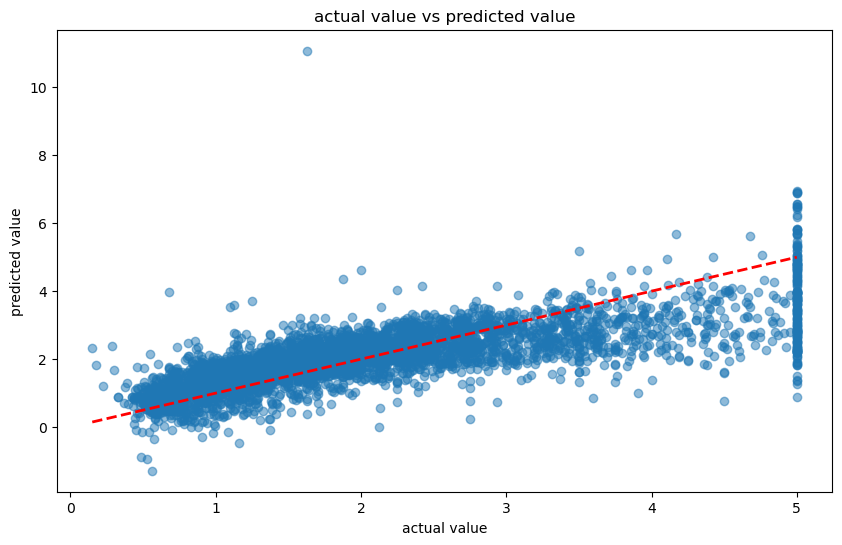

In [32]:
# 視覺化预测结果
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.title('actual value vs predicted value')
plt.show()

# 加上特徵重要性排序之預測效果比較

In [33]:
# 獲取特徵重要性排序
feature_ranking = pd.DataFrame({
    'feature': X.columns,
    'ranking': rfe_selector.ranking_
}).sort_values('ranking')

print("特徵重要性排序:")
print(feature_ranking)

特徵重要性排序:
      feature  ranking
0      MedInc        1
2    AveRooms        1
3   AveBedrms        1
6    Latitude        1
7   Longitude        1
1    HouseAge        2
5    AveOccup        3
4  Population        4


In [34]:
# 比較不同特徵數量的模型性能
results = []

for n_features in range(1, len(X.columns) + 1):
    selected_features = feature_ranking['feature'][:n_features].tolist()
    X_selected = X[selected_features]
    
    # 數據分割
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # 建立模型
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 預測和評估
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'n_features': n_features,
        'features': ', '.join(selected_features),
        'mse': mse,
        'r2': r2
    })


不同特徵數量的模型性能比較:
   n_features                                           features       mse  \
0           1                                             MedInc  0.709116   
1           2                                   MedInc, AveRooms  0.702155   
2           3                        MedInc, AveRooms, AveBedrms  0.675854   
3           4              MedInc, AveRooms, AveBedrms, Latitude  0.672073   
4           5   MedInc, AveRooms, AveBedrms, Latitude, Longitude  0.566770   
5           6  MedInc, AveRooms, AveBedrms, Latitude, Longitu...  0.556964   
6           7  MedInc, AveRooms, AveBedrms, Latitude, Longitu...  0.555953   
7           8  MedInc, AveRooms, AveBedrms, Latitude, Longitu...  0.555892   

         r2  
0  0.458859  
1  0.464171  
2  0.484242  
3  0.487127  
4  0.567487  
5  0.574969  
6  0.575741  
7  0.575788  


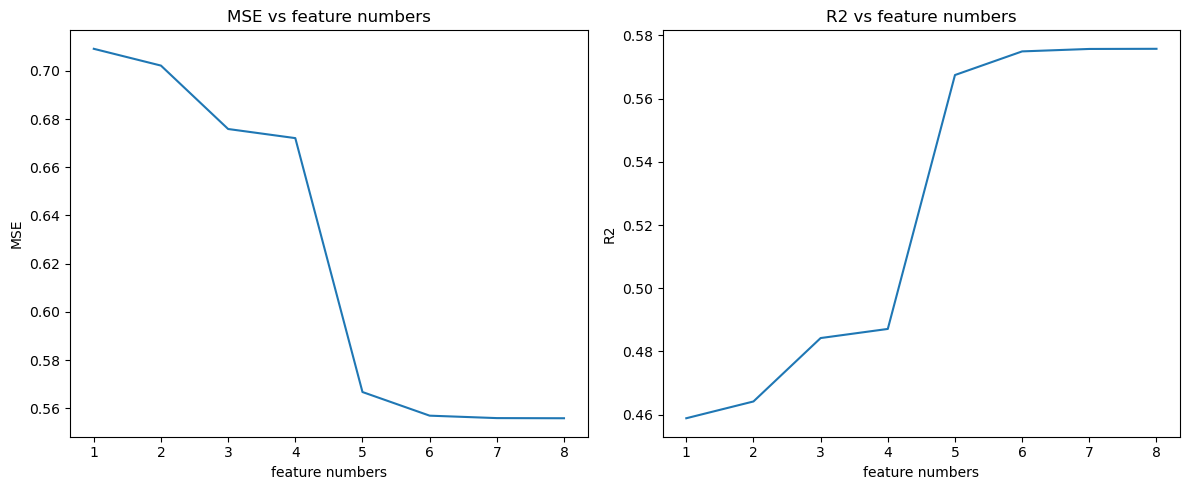

In [36]:
results_df = pd.DataFrame(results)
print("\n不同特徵數量的模型性能比較:")
print(results_df)

# 繪製MSE和R2隨特徵數量變化的圖表
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['n_features'], results_df['mse'])
plt.title('MSE vs feature numbers')
plt.xlabel('feature numbers')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(results_df['n_features'], results_df['r2'])
plt.title('R2 vs feature numbers')
plt.xlabel('feature numbers')
plt.ylabel('R2')

plt.tight_layout()
plt.show()